In [33]:

# wrapper que integra Keras (TensorFlow) com Scikit-Learn para facilitar o uso de GridSearchCV - pois antes o KerasRegressor nao esta funcionando (from keras.wrappers.scikit_learn import KerasRegressor)
# !pip install scikeras

# Acessar os valores das ações, petróleo (brent), ibovespa e minério de ferro
# !pip install yfinance

# Acessar a variável de entrada do fechamento do dólar
# !pip install python-bcb==0.3.3

# Foi preciso dar upgrade para rodar os imports
# !pip install --upgrade scikit-learn

In [34]:
## 1. Importação de Bibliotecas

# Leitura, interpretação e plotar os dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Normalização e avaliação do modelo
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# Construção do modelo LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Bases para as variáveis de entrada (features)
import yfinance as yf
from bcb import sgs

# Tempo de compilação, variáveis do sistema e aleatoriedade
import time
import os
import random

In [35]:
## 2. Criação de uma SEED

SEED = 0

def criar_seed(seed=SEED):
  os.environ['PYTHONHASHSEED'] = str(seed) # controla aleatoriedade interna do interpretador Python
  random.seed(seed) # controla aleatoriedade da biblioteca random
  np.random.seed(seed) # controla aleatoriedade do NumPy
  tf.random.set_seed(seed) # controla aleatoriedade do TensorFlow (pesos, embaralhamento, etc)

def setar_deterministico(seed=SEED): # garantir que se obtenha os mesmos valores ao rodar o código novamente
  criar_seed(seed=seed) # setar as seeds
  os.environ['TF_DETERMINISTIC_OPS'] = '1' # força o TensorFlow a usar operações determinísticas
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1' # força operações determinísticas específicas da GPU (cuDNN)
  tf.config.threading.set_inter_op_parallelism_threads(1) # limita o paralelismo entre operações a 1 thread
  tf.config.threading.set_intra_op_parallelism_threads(1) # limita o paralelismo dentro de cada operação a 1 thread

setar_deterministico(SEED)  # Executa tudo acima com a seed escolhida

In [36]:
## 3. Coleta dos Dados

# Tempo inicial de compilação
_start_time = time.time()

# Datas de início e fim das features
start = '2016-09-01'
end = '2023-09-01'

# Dados da BBDC4 (Close e Volume)
vale = yf.download('BBDC4.SA', start=start, end=end)[['Close', 'Volume']] # filtra o período dos dados desejado e quais colunas deseja pegar da base de dados
vale.columns = ['Close_BBDC4', 'Volume_BBDC4'] # renomeia a coluna

# Dólar
dolar = sgs.get({'Close_Dolar': 1}, start=start, end=end).reset_index() # faz com que Date deixe de ser index e passe a ser uma coluna junto ao Close_Dolar
dolar['Date'] = pd.to_datetime(dolar['Date']) # muda o type da coluna Date para Datetime para ficar igual as demais variáveis
dolar.set_index('Date', inplace=True) # retorna Date para index, pois é assim que as demais variáveis estão

# Petróleo (WTI) pelo Yahoo Finance
petroleo = yf.download('CL=F', start=start, end=end)[['Close']] # preço do barril de petróleo WTI
petroleo.columns = ['Close_Petroleo']

# Ibovespa
ibov = yf.download('^BVSP', start=start, end=end)[['Close']] # índice ibovespa
ibov.columns = ['Close_Ibovespa']

# Minério de Ferro (supondo índice internacional)
minerio = yf.download('RIO', start=start, end=end)[['Close']] # mineradora Rio Tinto
minerio.columns = ['Close_Minerio']

C:\Users\felip\AppData\Local\Temp\ipykernel_7332\1626282488.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vale = yf.download('BBDC4.SA', start=start, end=end)[['Close', 'Volume']] # filtra o período dos dados desejado e quais colunas deseja pegar da base de dados
[*********************100%***********************]  1 of 1 completed
C:\Users\felip\AppData\Local\Temp\ipykernel_7332\1626282488.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  petroleo = yf.download('CL=F', start=start, end=end)[['Close']] # preço do barril de petróleo WTI
[*********************100%***********************]  1 of 1 completed
C:\Users\felip\AppData\Local\Temp\ipykernel_7332\1626282488.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ibov = yf.download('^BVSP', start=start, end=end)[['Close']] # índice ibovespa
[*********************100%***********************]  1 of 1 completed
C:\Users\felip\Ap

In [37]:
## 4. Preparação e Merge dos Dados

# Unificar tudo em um DataFrame
df = vale.copy() # cria uma cópia do dataframe para ir dando o merge
df = df.merge(dolar, left_index=True, right_index=True, how='left') # junta os dados ao dataframe principal a partir do index (date)
df = df.merge(petroleo, left_index=True, right_index=True, how='left')
df = df.merge(ibov, left_index=True, right_index=True, how='left')
df = df.merge(minerio, left_index=True, right_index=True, how='left')

# Remover valores nulos
df.dropna(inplace=True)

In [38]:
## 5. Normalização

scaler = MinMaxScaler() # usa o minmaxscaler como normalizador para escalar os dados entre 0 e 1
dados_escalados = scaler.fit_transform(df) # aplica o normalizador a todos os dados numéricos

In [39]:
## 6. Criação da Janela Deslizante (21 dias)

def createXY(dataset, n_past): # função que cria as janelas deslizantes
    dataX, dataY = [], []
    for i in range(n_past, len(dataset)): # começa no n_past (=21)
        dataX.append(dataset[i - n_past:i, :]) # para cada ponto no tempo, pega os últimos 'n_past' dias como entrada (X)
        dataY.append(dataset[i, 0]) # a saída (y) será o valor de fechamento da VALE3 no dia seguinte; o índice 0 representa o Close_Vale3 que vai ser a variável de saída (predição)
    return np.array(dataX), np.array(dataY)

X, y = createXY(dados_escalados, 21) # gera os arrays X (entradas) e y (saídas) com uma janela de 21 dias

# Separar treino e teste (80/20)
split = int(len(X) * 0.8) # faz o corte de 80% dos dados
X_train, X_test = X[:split], X[split:] # train (treino) = 80% dos dados; test (teste) = 20% dos dados --> X
y_train, y_test = y[:split], y[split:] # train (treino) = 80% dos dados; test (teste) = 20% dos dados --> Y

In [40]:
## 7. Construção do Modelo com GridSearchCV (2ª arquitetura)

def build_model(optimizer='adam'): # função para criar o modelo LSTM como base para o GridSearchCV
    model = Sequential() # cria um modelo sequencial (camadas empilhadas)
    model.add(LSTM(32, return_sequences=True, input_shape=(15, X_train.shape[2]))) # primeira camada LSTM com 128 neurônios e retorno da sequência para a próxima LSTM
    # model.add(Dropout(0.1)) # dropout após a primeira LSTM (evita overfitting logo na entrada)
    model.add(LSTM(16)) # segunda camada LSTM com 64 neurônios (sem return_sequences, pois é a última LSTM)
    # model.add(Dropout(0.1))
    model.add(Dense(10)) # camada densa intermediária com 10 neurônios (pode ajudar a refinar a saída)
    model.add(Dense(1)) # camada de saída com 1 neurônio (regressão: previsão de um único valor)
    model.compile(optimizer=optimizer, loss='mse') # compila o modelo com o otimizador informado e função de erro MSE (erro quadrático médio)
    return model


model = KerasRegressor(model=build_model, verbose=1) # envolve o modelo Keras dentro de um wrapper compatível com scikit-learn (necessário para o GridSearchCV)

params = { # definição dos hiperparâmetros
    'batch_size': [16], # tamanhos de lote a testar
    'epochs': [90], # número de épocas de treino
    'optimizer': ['adam'] # otimizador usado na compilação
}

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

grid = GridSearchCV(estimator=model, param_grid=params, scoring=mae_scorer, cv=4) # inicializa o GridSearchCV para encontrar os melhores hiperparâmetros usando validação cruzada (cv=3)
grid_result = grid.fit(X_train, y_train) # realiza o treinamento e busca dos melhores parâmetros

Epoch 1/90


c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0514
Epoch 2/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0064
Epoch 3/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0051
Epoch 4/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043
Epoch 5/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035
Epoch 6/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031
Epoch 7/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029
Epoch 8/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027
Epoch 9/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025
Epoch 10/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024
Epoch 11/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023
Epoch 12/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022
Epoch 13/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022
Epoch 14/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021
Epoch 15/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020
Epoch 16/90
63/63 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0200
Epoch 2/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041
Epoch 3/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035
Epoch 4/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031
Epoch 5/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026
Epoch 6/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023
Epoch 7/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022
Epoch 8/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021
Epoch 9/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020
Epoch 10/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 11/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 12/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 13/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 14/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 15/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 16/90
63/63 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0395
Epoch 2/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040
Epoch 3/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030
Epoch 4/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028
Epoch 5/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025
Epoch 6/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023
Epoch 7/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021
Epoch 8/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020
Epoch 9/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 10/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 11/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 12/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 13/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 14/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 15/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 16/90
63/63 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0259
Epoch 2/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047
Epoch 3/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038
Epoch 4/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034
Epoch 5/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029
Epoch 6/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026
Epoch 7/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024
Epoch 8/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023
Epoch 9/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022
Epoch 10/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021
Epoch 11/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020
Epoch 12/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020
Epoch 13/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 14/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 15/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 16/90
63/63 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0242
Epoch 2/90
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0044
Epoch 3/90
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0038
Epoch 4/90
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0033
Epoch 5/90
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0030
Epoch 6/90
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026
Epoch 7/90
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024
Epoch 8/90
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022
Epoch 9/90
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0021
Epoch 10/90
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0019
Epoch 11/90
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0018
Epoch 12/90
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0018
Epoch 13/90
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0017
Epoch 14/90
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016
Epoch 15/90
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 16/90
84/84 ━━━━━━━━━━━━

In [41]:
## 8. Avaliação do Modelo

best_model = grid_result.best_estimator_ # recupera o melhor modelo encontrado pelo GridSearchCV
pred = best_model.predict(X_test) # faz a predição dos valores do conjunto de teste

# Expande as previsões para 6 colunas simuladas (como se fossem as 6 features)
pred_expand = np.repeat(pred.reshape(-1, 1), df.shape[1], axis=1) # expande a predição para ter o mesmo número de colunas que o DataFrame original (necessário para desfazer a normalização)
y_expand = np.repeat(y_test.reshape(-1, 1), df.shape[1], axis=1) # faz o mesmo com os valores reais (y_test), para poder comparar os dados reais com os previstos no mesmo formato

# Inverte a normalização e pega só a primeira coluna (Close_VALE3)
pred_real = scaler.inverse_transform(pred_expand)[:, 0] # inverte a normalização nas previsões e pega só a 1ª coluna (preço da VALE3)
y_real = scaler.inverse_transform(y_expand)[:, 0] # inverte a normalização nos valores reais (y_test) e pega só a 1ª coluna

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [42]:
## 9. Métricas

print("MAE:", mean_absolute_error(y_real, pred_real)) # erro absoluto médio (MAE)
print("MAPE:", mean_absolute_percentage_error(y_real, pred_real)) # erro percentual médio absoluto (MAPE)
print("R²:", r2_score(y_real, pred_real)) # R² (quanto o modelo explica da variabilidade dos dados)

MAE: 0.23231793592076103
MAPE: 0.01779191719278675
R²: 0.9626842865215866


In [43]:
resultados = pd.DataFrame(grid_result.cv_results_)
display(resultados[['params', 'mean_test_score', 'rank_test_score']])

,params,mean_test_score,rank_test_score
0,"{'batch_size': 16, 'epochs': 90, 'optimizer': ...",-0.032931,1


In [44]:
grid_result.best_params_

{'batch_size': 16, 'epochs': 90, 'optimizer': 'adam'}

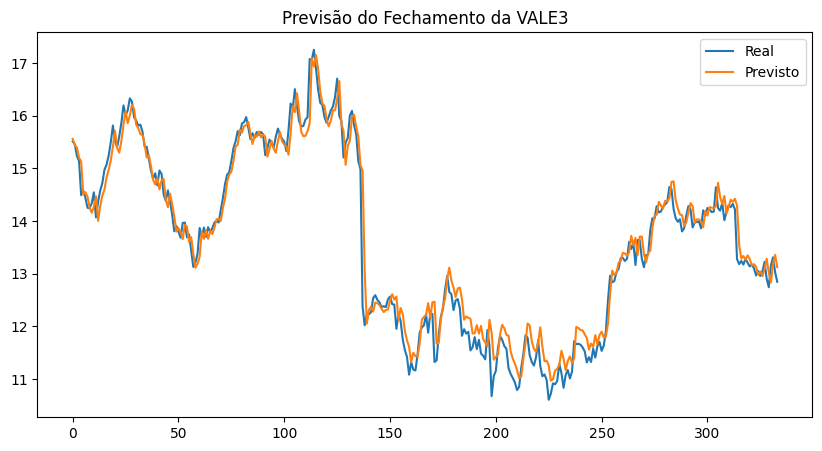

In [45]:
## 10. Gráfico

plt.figure(figsize=(10,5))
plt.plot(y_real, label='Real')
plt.plot(pred_real, label='Previsto')
plt.legend()
plt.title('Previsão do Fechamento da VALE3')
plt.show()

In [46]:
## 11. Tempo Final de Compilação
_end_time = time.time() - _start_time
print(f"Tempo total de execução: {_end_time:.2f} segundos")

Tempo total de execução: 217.05 segundos
